## Bitcoin Volatility Prediction

#### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.dates as mdates
from sklearn import linear_model
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
import os

- 기본

In [2]:
def convert_tick_to_ohlcv(data):
    """
    Converts given Binance tick data into 1-hour interval OHLCV (Open, High, Low, Close, Volume) data.
    :param data: DataFrame with Tick data
    :return: DataFrame with the Open, High, Low, Close, Volume values
    """

    data['time'] = pd.to_datetime(data['time'], unit='ms')
    ohlcv = data.resample('1H', on='time').agg({
        'price': ['first', 'max', 'min', 'last'],
        'qty': 'sum',
        'price': 'mean',
        'quote_qty': 'std',
        'is_buyer_maker': 'sum'
        
})

    ohlcv.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    return ohlcv

def calculate_volatility(data, window=20):
    """
    Calculate the rolling volatility using the standard deviation of returns.
    :param data: DataFrame with OHLCV data
    :param window: The number of periods to use for calculating the standard deviation
    :return: DataFrame with the volatility values
    """

    # Calculate daily returns
    data['returns'] = data['Close'].pct_change()

    # Calculate the rolling standard deviation of returns
    data['volatility'] = data['returns'].rolling(window=window).std()

    return data

#### Loading Data

In [3]:
df = pd.read_csv('../data/BIT_2023_1차.csv')
df.set_index('time', inplace=True)
df.index=pd.to_datetime(df.index)

In [4]:
df.isnull().sum()

Open               24
High               24
Low                24
Close              24
Volume              0
returns            12
volatility        186
price              24
quote_qty          24
is_buyer_maker      0
quote_qty_cal      24
dtype: int64

### 1. Preprocessing

#### Checking Missing Value

- price(Open, High, Low, Close, price), quote_qty, quote_qty_cal

In [5]:
df[df['price'].isnull()].index 

DatetimeIndex(['2023-01-23 21:00:00', '2023-01-23 22:00:00',
               '2023-01-23 23:00:00', '2023-01-24 21:00:00',
               '2023-01-24 22:00:00', '2023-01-24 23:00:00',
               '2023-01-25 16:00:00', '2023-01-25 17:00:00',
               '2023-01-25 18:00:00', '2023-01-25 19:00:00',
               '2023-01-25 20:00:00', '2023-01-25 21:00:00',
               '2023-01-25 22:00:00', '2023-01-25 23:00:00',
               '2023-01-26 22:00:00', '2023-01-26 23:00:00',
               '2023-03-14 23:00:00', '2023-03-15 22:00:00',
               '2023-03-15 23:00:00', '2023-11-21 03:00:00',
               '2023-11-21 04:00:00', '2023-11-21 05:00:00',
               '2023-11-21 06:00:00', '2023-11-21 07:00:00'],
              dtype='datetime64[ns]', name='time', freq=None)

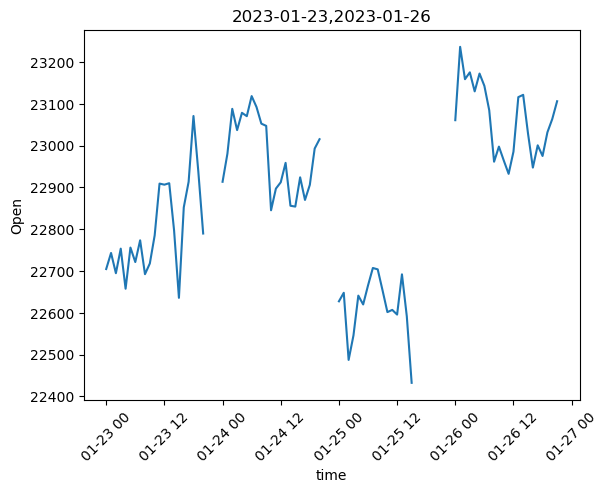

In [6]:
# 날짜 범위 선택
start_date = '2023-01-23'
end_date = '2023-01-26'
df_filtered = df.loc[start_date:end_date]

# 플롯 그리기
plt.plot(df_filtered.index, df_filtered['Open'])
plt.xlabel('time')
plt.ylabel('Open')
plt.title('2023-01-23,2023-01-26')
plt.xticks(rotation=45)
plt.show()

- returns

In [7]:
df[df['returns'].isnull()].index # 매달 1일

DatetimeIndex(['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01',
               '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01',
               '2023-09-01', '2023-10-01', '2023-11-01', '2023-12-01'],
              dtype='datetime64[ns]', name='time', freq=None)

- volatility

In [8]:
df[df['volatility'].isnull()].index # 매달 첫 20행 결측(windows = 20)

DatetimeIndex(['2023-01-01 00:00:00', '2023-01-01 01:00:00',
               '2023-01-01 02:00:00', '2023-01-01 03:00:00',
               '2023-01-01 04:00:00', '2023-01-01 05:00:00',
               '2023-01-01 06:00:00', '2023-01-01 07:00:00',
               '2023-01-01 08:00:00', '2023-01-01 09:00:00',
               ...
               '2023-12-01 10:00:00', '2023-12-01 11:00:00',
               '2023-12-01 12:00:00', '2023-12-01 13:00:00',
               '2023-12-01 14:00:00', '2023-12-01 15:00:00',
               '2023-12-01 16:00:00', '2023-12-01 17:00:00',
               '2023-12-01 18:00:00', '2023-12-01 19:00:00'],
              dtype='datetime64[ns]', name='time', length=186, freq=None)

#### Imputation of missing values

In [9]:
def spline_interpolate_column(df, column_name, order=3):
    df[column_name] = df[column_name].interpolate(method='spline', order=order)

In [10]:
columns_to_interpolate = ['Open', 'High', 'Low', 'Close','price']

for column in columns_to_interpolate:
    spline_interpolate_column(df, column, order=3)

In [11]:
columns_to_interpolate_volume = ['quote_qty','quote_qty_cal']

for column in columns_to_interpolate:
    spline_interpolate_column(df, column, order=3)

- 보간 후

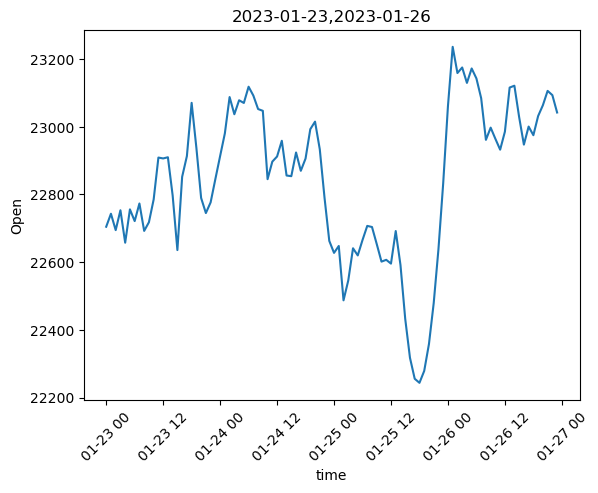

In [12]:
# 날짜 범위 선택
start_date = '2023-01-23'
end_date = '2023-01-26'
df_filtered = df.loc[start_date:end_date]

# 플롯 그리기
plt.plot(df_filtered.index, df_filtered['Open'])
plt.xlabel('time')
plt.ylabel('Open')
plt.title('2023-01-23,2023-01-26')
plt.xticks(rotation=45)
plt.show()

- returns, volatility > 논의 필요

In [13]:
df.dropna(inplace = True) # 임시

### 2.EDA

#### (Baseline Model)

In [16]:
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def rf_base(train_df, test_df, df_name=''): #df_name : 데이터 프레임 구분용, train_df 이름 기입
    X_train = train_df.drop('volatility', axis=1)
    y_train = train_df['volatility']
    
    X_test = test_df.drop('volatility', axis=1)
    y_test = test_df['volatility']

    # RandomForestRegressor
    rf_model = RandomForestRegressor()

    # 모델 학습
    rf_model.fit(X_train, y_train)

    # 예측
    y_pred = rf_model.predict(X_test)
    
    # 예측값 실제값 시각화
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(y_test.values, label='Actual', marker='o')
    ax.plot(y_pred, label='Predicted', marker='x')
    ax.set_title(f'{df_name} - Actual vs Predicted')
    ax.set_xlabel('Index')
    ax.set_ylabel('Volatility')
    ax.legend()
    plt.show()


    # 평가지표(MAPE, RMSE)
    test_mape = calculate_mape(y_test, y_pred)
    test_rmse = calculate_rmse(y_test, y_pred)
    print(f'{df_name} : MAPE: {test_mape}, RMSE: {test_rmse}')

- Baseline Model test(테스트용)

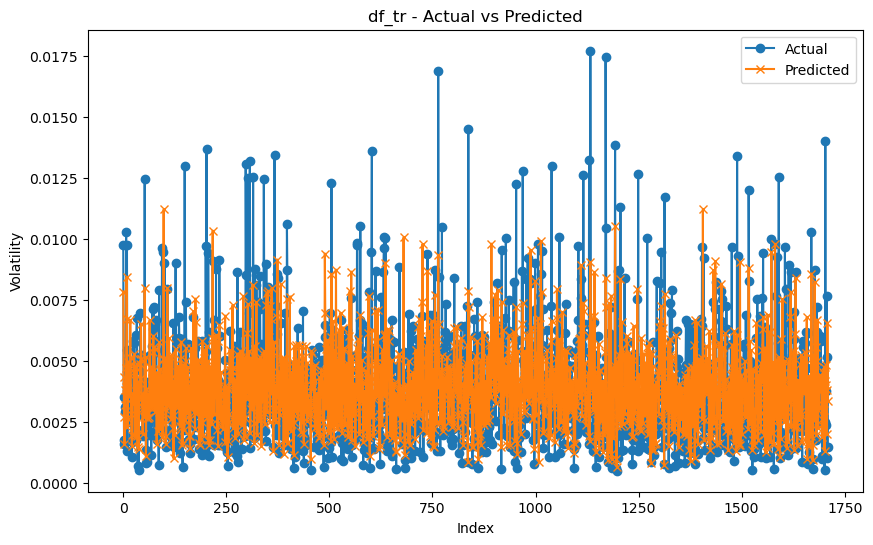

df_tr : MAPE: 40.41509053636933, RMSE: 0.0018648255378839098


In [15]:
df_tr, df_te = train_test_split(df, test_size=0.2, random_state=42)
rf_base(df_tr, df_te, 'df_tr')

#### Stationary(세희)
- 정상성 검정 > 차분 

#### Technical Indicators

In [16]:
# MACD 함수
def MACD(df, short_window, long_window, signal_window):
    
    df[f'Short_MA_{short_window}'] = df['Close'].ewm(span=short_window, adjust=False).mean()
    df[f'Long_MA_{long_window}'] = df['Close'].ewm(span=long_window, adjust=False).mean()
    df[f'MACD_{short_window}{long_window}'] = df[f'Short_MA_{short_window}'] - df[f'Long_MA_{long_window}']
    df[f'Signal_Line_{signal_window}'] = df[f'MACD_{short_window}{long_window}'].ewm(span=signal_window, adjust=False).mean()
    df[f'MACD_Oscillator_{short_window}{long_window}'] = df[f'MACD_{short_window}{long_window}'] - df[f'Signal_Line_{signal_window}']
    
    return df
    
# Stochastic Oscillator 함수
def cal_stoc_os(df, period=14, m=3): # period = 14 or 20
    
    # 최근 N일간의 최고가(H)와 최저가(L)
    df['highest_high'] = df['High'].rolling(window=period).max()
    df['lowest_low'] = df['Low'].rolling(window=period).min()
    
    # %K 계산
    df['%K'] = (df['Close'] - df['lowest_low']) / (df['highest_high'] - df['lowest_low']) * 100
    
    # %D 계산
    df['%D'] = df['%K'].rolling(m).mean()
    
    return df
    
# ATR 함수
def calculate_atr(df, period=14):
    # True Range 계산
    df['high-low'] = df['High'] - df['Low']
    df['high-close'] = abs(df['High'] - df['Close'].shift())
    df['low-close'] = abs(df['Low'] - df['Close'].shift())
    
    df['true_range'] = df[['high-low', 'high-close', 'low-close']].max(axis=1)
    
    # ATR 계산
    df['atr'] = df['true_range'].rolling(window=period, min_periods=1).mean()
    
    # 임시 열 삭제
    df.drop(['high-low', 'high-close', 'low-close', 'true_range'], axis=1, inplace=True)
    
    return df

def bollinger_bands(df, window=20, num_std_dev=1.5):
    
    # 이동평균 계산
    df['rolling_mean'] = df['price'].rolling(window=window).mean()

    # 표준편차 계산
    df['rolling_std'] = df['price'].rolling(window=window).std()

    # 볼린저 밴드 상단 및 하단 계산
    df['upper_band'] = df['rolling_mean'] + (num_std_dev * df['rolling_std'])
    df['lower_band'] = df['rolling_mean'] - (num_std_dev * df['rolling_std'])

    # 필요없는 컬럼 삭제
    df.drop(['rolling_mean', 'rolling_std'], axis=1, inplace=True)

    return df

def calculate_uo(df, period1=7, period2=10, period3=14):
    # True Range 계산
    df['true_range'] = df['High'].combine(df['Close'].shift(1), max) - df['Low'].combine(df['Close'].shift(1), min)
    
    # Average True Range (ATR) 계산
    df['avg_true_range1'] = df['true_range'].rolling(window=period1, min_periods=1).mean()
    df['avg_true_range2'] = df['true_range'].rolling(window=period2, min_periods=1).mean()
    df['avg_true_range3'] = df['true_range'].rolling(window=period3, min_periods=1).mean()

    # Buying Pressure 계산
    df['buying_pressure'] = df['Close'] - df[['Open', 'Close']].min(axis=1)

    # True Buying Pressure (TBP) 계산
    df['true_buying_pressure1'] = df['buying_pressure'].rolling(window=period1, min_periods=1).sum()
    df['true_buying_pressure2'] = df['buying_pressure'].rolling(window=period2, min_periods=1).sum()
    df['true_buying_pressure3'] = df['buying_pressure'].rolling(window=period3, min_periods=1).sum()

    # UO 계산
    df['UO'] = (
        100
        * (4 * df['true_buying_pressure1'] / df['avg_true_range1'])
        + 2 * (4 * df['true_buying_pressure2'] / df['avg_true_range2'])
        + (df['true_buying_pressure3'] / df['avg_true_range3'])
    ) / (4 + 2 + 1)

    # 필요 없는 열 제거
    df = df.drop(['true_range', 'avg_true_range1', 'avg_true_range2', 'avg_true_range3',
                  'buying_pressure', 'true_buying_pressure1', 'true_buying_pressure2', 'true_buying_pressure3'], axis=1)

    return df

#### Technical Indicators - Optimization

1. 결측치
2. 평가지표 비교
* 수익률: 볼린저 밴드를 기반으로 한 수익률을 평가하는 지표로, 해당 지표가 가격의 특이값을 얼마나 잘 캐치하고 이에 따른 수익을 얼마나 창출하는지를 측정.
* 변동성: 볼린저 밴드를 기반으로 주가의 변동성을 얼마나 잘 포착하는지를 확인하는 지표
* 최대 손실: 볼린저 밴드를 기반으로 투자 전략이 어떤 상황에서 최대 손실을 겪는지 확인하는 지표
* 승률: 볼린저 밴드의 신호가 실제로 가격의 특이값을 잘 나타내고 있는지 확인하는 지표로, 해당 기준은 상한선('upper_band')를 넘는 경우를 '승리'로 간주.

##### Stochastic Oscillator
일반적으로는 14와 3을 사용한다. 
- period의 경우, 주가 데이터의 기간에 따라 최적의 값을 설정할 수 있다. 예를 들어, 10일, 30일, 50일 등 다양한 기간을 선택할 수 있다.
- m은 %K의 이동평균을 계산하는데 사용되는 기간이다. 따라서, 2, 5, 10 등 다른 값을 설정할 수도 있다.
> 주가 데이터의 특성과 분석 목적에 따라 period와 m의 값을 조정하여 최적의 결과를 얻을 수 있다

In [17]:
# 평가 지표를 저장 딕셔너리
evaluation_results = {}

# period와 m의 다양한 조합 설정
periods = [14, 20, 30]  # 다양한 period
ms = [2, 3, 5, 10]  # 다양한 m

# 각 조합 평가 지표 계산
for period in periods:
    for m in ms:
        df_copy = df.copy()
        df_copy = cal_stoc_os(df_copy, period=period, m=m)
        
        # 평가 지표 계산 (수익률, 변동성, 최대 손실, 승률)
        returns = df_copy['Close'].pct_change().cumsum().iloc[-1]
        volatility = df_copy['Close'].pct_change().std() 
        max_drawdown = (df_copy['Close'].cummax() - df_copy['Close']).max()
        win_rate = (df_copy['%K'] > df_copy['%D']).mean()
        
        # 결측치 계산
        k_na = df_copy['%K'].isna().sum()  # 수정된 부분
        d_na = df_copy['%D'].isna().sum()  # 수정된 부분
        
        # 평가 지표 -> 딕셔너리에 저장
        evaluation_results[(period, m)] = {
            'Returns': returns,
            'Volatility': volatility,
            'Max Drawdown': max_drawdown,
            'Win Rate': win_rate,
            'k_na': k_na,
            'd_na': d_na
            
        }

# 평가 지표를 기준으로 가장 좋은 조합?
best_combination = max(evaluation_results, key=lambda x: evaluation_results[x]['Returns'])

# 결과
print("Evaluation Results:")
for combination, metrics in evaluation_results.items():
    print(f"Period={combination[0]}, m={combination[1]}")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    print()

print("Best Combination:")
print(f"Period={best_combination[0]}, m={best_combination[1]}")


Evaluation Results:
Period=14, m=2
Returns: 1.0265016527662556
Volatility: 0.004598917056339164
Max Drawdown: 6592.299999999999
Win Rate: 0.5072514619883041
k_na: 13
d_na: 14

Period=14, m=3
Returns: 1.0265016527662556
Volatility: 0.004598917056339164
Max Drawdown: 6592.299999999999
Win Rate: 0.5025730994152047
k_na: 13
d_na: 15

Period=14, m=5
Returns: 1.0265016527662556
Volatility: 0.004598917056339164
Max Drawdown: 6592.299999999999
Win Rate: 0.5009356725146199
k_na: 13
d_na: 17

Period=14, m=10
Returns: 1.0265016527662556
Volatility: 0.004598917056339164
Max Drawdown: 6592.299999999999
Win Rate: 0.5052631578947369
k_na: 13
d_na: 22

Period=20, m=2
Returns: 1.0265016527662556
Volatility: 0.004598917056339164
Max Drawdown: 6592.299999999999
Win Rate: 0.5042105263157894
k_na: 19
d_na: 20

Period=20, m=3
Returns: 1.0265016527662556
Volatility: 0.004598917056339164
Max Drawdown: 6592.299999999999
Win Rate: 0.5012865497076023
k_na: 19
d_na: 21

Period=20, m=5
Returns: 1.0265016527662556


##### Boolinger Band
일반적으로 20일과 2배수를 사용

* window 값 설정은 주가의 변동을 얼마나 민감하게 볼 것인가에 따라 결정함

  기본값 : 20일이며, 10일~50일 사이의 값

  작은 값으로 설정 시 짧은 주기 동안의 가격 움직임을 빠르게 파악할 수 있고, 큰 값 설정 시 긴 주기의 추세를 부드럽게 나타낼 수 있습니다.

* 표준편차 배수 설정은 주가의 움직임을 어느 폭까지 감지할 것인가에 따라 결정할 수 있습니다.

  기본값은 2이고, 1.5 또는 2 값이 적절합니다.

  작은 값 설정 시 움직임을 파악하는 폭이 좁아져서 특이한 움직임이나 극단적인 상황을 감지하기 어렵고, 큰 값 설정 시 큰 변동성을 감지하기 용이합니다.

> **표준편차 배수 : 1.5와 2 확인 필요.**

> **window 값 : 짧은 주기 설정이 필요하다는 판단 하에 10일, 15일, 20일 경우 확인.**

> window 값이 10이고 표준편차 배수가 1.5일 때 가장 적음

In [18]:
#평가 지표 저장 딕셔너리 생성
evaluation_results = {}

#가능한 조합의 평가 지표(수익률, 변동성, 최대 손실, 승률) 계산
for window in [10, 15, 20]:
    for num_std_dev in [1.5, 2]:
        
        #볼린저 밴드 생성 및 조합 적용
        df_copy = df.copy()
        df_copy = bollinger_bands(df_copy, window=window, num_std_dev=num_std_dev)
        
        #평가 지표 계산
        returns = df_copy['Close'].pct_change().cumsum().iloc[-1]
        volatility = df_copy['Close'].pct_change().std()
        max_drawdown = (df_copy['Close'].cummax() - df_copy['Close']).max()
        win_rate = (df_copy['Close'] > df_copy['upper_band']).mean()
    
        #결측치 여부 확인
        upper_band_na = df_copy['upper_band'].isna().sum()
        lower_band_na = df_copy['lower_band'].isna().sum()
        
        #평가 지표 및 결측치 저장
        evaluation_results[(window, num_std_dev)] = {
            'Returns': returns,
            'Volatility': volatility,
            'Max Drawdown': max_drawdown,
            'Win Rate': win_rate,
            'Upper Band NA': upper_band_na,
            'Lower Band NA': lower_band_na
        }

#가장 좋은 조합 찾기(returns 기준)
best_combination = max(evaluation_results, key=lambda x: evaluation_results[x]['Returns'])

# 결과 출력
print("Evaluation Results:")
for combination, metrics in evaluation_results.items():
    print(f"window={combination[0]}, num_std_dev={combination[1]}")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    print()

print("Best Combination:")
print(f"window={best_combination[0]}, num_std_dev={best_combination[1]}")


Evaluation Results:
window=10, num_std_dev=1.5
Returns: 1.0265016527662556
Volatility: 0.004598917056339164
Max Drawdown: 6592.299999999999
Win Rate: 0.14011695906432747
Upper Band NA: 9
Lower Band NA: 9

window=10, num_std_dev=2
Returns: 1.0265016527662556
Volatility: 0.004598917056339164
Max Drawdown: 6592.299999999999
Win Rate: 0.07356725146198831
Upper Band NA: 9
Lower Band NA: 9

window=15, num_std_dev=1.5
Returns: 1.0265016527662556
Volatility: 0.004598917056339164
Max Drawdown: 6592.299999999999
Win Rate: 0.14748538011695905
Upper Band NA: 14
Lower Band NA: 14

window=15, num_std_dev=2
Returns: 1.0265016527662556
Volatility: 0.004598917056339164
Max Drawdown: 6592.299999999999
Win Rate: 0.08105263157894736
Upper Band NA: 14
Lower Band NA: 14

window=20, num_std_dev=1.5
Returns: 1.0265016527662556
Volatility: 0.004598917056339164
Max Drawdown: 6592.299999999999
Win Rate: 0.1497076023391813
Upper Band NA: 19
Lower Band NA: 19

window=20, num_std_dev=2
Returns: 1.0265016527662556
V

#### Technical Indicators Generation

In [20]:
MACD(df, 6, 13, 4) # 단기추세 감지 but 노이즈에 민감할 가능성 있음
MACD(df, 12, 26, 9) # 일반적인 window 계수 but 변동성이 큰 시장에선 느리게 반응할 수 있음
MACD(df, 5, 26, 9) 
calculate_atr(df)
calculate_atr(df, period = 20)

cal_stoc_os(df) # periods = 14
cal_stoc_os(df, period = 20, m = 2)
cal_stoc_os(df, period = 14, m = 2)
cal_stoc_os(df, period = 30, m = 2)

cal_stoc_os(df, period = 20, m = 3)
cal_stoc_os(df, period = 14, m = 3)
cal_stoc_os(df, period = 30, m = 3)

cal_stoc_os(df, period = 20, m = 5)
cal_stoc_os(df, period = 14, m = 5)
cal_stoc_os(df, period = 30, m = 5)

cal_stoc_os(df, period = 20, m = 10)
cal_stoc_os(df, period = 14, m = 10)
cal_stoc_os(df, period = 30, m = 10)

bollinger_bands(df) # windows = 20
bollinger_bands(df, window = 15)
bollinger_bands(df, window = 10)
bollinger_bands(df, num_std_dev= 2)
bollinger_bands(df, window = 15,num_std_dev= 2)
bollinger_bands(df, window = 10, num_std_dev= 2)

calculate_uo(df)

,Open,High,Low,Close,Volume,returns,volatility,price,quote_qty,is_buyer_maker,...,Short_MA_5,MACD_526,MACD_Oscillator_526,atr,highest_high,lowest_low,%K,%D,upper_band,lower_band
time,,,,,,,,,,,,,,,,,,,,,
2023-01-01 20:00:00,16596.1,16618.8,16592.0,16593.8,4951.995,-0.000139,0.000824,16604.578969,7755.192178,15436,...,16593.800000,0.000000,0.000000,26.800,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 21:00:00,16593.7,16599.7,16584.1,16597.6,3040.626,0.000229,0.000773,16592.678507,5988.572184,10807,...,16595.066667,0.985185,0.788148,21.200,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 22:00:00,16597.6,16605.4,16579.1,16594.4,3633.682,-0.000193,0.000763,16591.705509,7402.187094,11318,...,16594.844444,0.739369,0.433866,22.900,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 23:00:00,16594.4,16617.4,16594.4,16610.3,5040.212,0.000958,0.000749,16604.731182,8303.054581,13189,...,16599.996296,4.691597,3.508875,22.925,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02 00:00:00,16610.4,16618.4,16572.9,16578.0,5774.202,-0.001945,0.000873,16592.870115,7729.667724,18099,...,16592.664198,-1.358672,-2.033116,27.440,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,42701.7,42741.9,42624.7,42659.9,3944.096,-0.000977,0.003040,42679.290530,14458.392200,23305,...,42637.906153,169.125134,15.126558,227.820,42951.0,42001.0,69.357895,70.965061,42759.297406,42450.999570
2023-12-31 20:00:00,42659.9,42724.5,42543.3,42599.1,4730.936,-0.001425,0.002863,42625.853600,12326.119420,28014,...,42624.970769,146.536492,-5.969668,221.385,42951.0,42001.0,62.957895,69.088831,42721.008996,42467.649282
2023-12-31 21:00:00,42599.2,42717.0,42558.2,42558.9,3794.010,-0.000944,0.002673,42634.523520,13367.479780,21732,...,42602.947179,118.552478,-27.162945,215.100,42951.0,42001.0,58.726316,67.739478,42722.770296,42467.450398


In [21]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'returns', 'volatility',
       'price', 'quote_qty', 'is_buyer_maker', 'quote_qty_cal', 'Short_MA_6',
       'Long_MA_13', 'MACD_613', 'Signal_Line_4', 'MACD_Oscillator_613',
       'Short_MA_12', 'Long_MA_26', 'MACD_1226', 'Signal_Line_9',
       'MACD_Oscillator_1226', 'Short_MA_5', 'MACD_526', 'MACD_Oscillator_526',
       'atr', 'highest_high', 'lowest_low', '%K', '%D', 'upper_band',
       'lower_band'],
      dtype='object')

### Model Efficiency Optimization

- kfold